In [63]:
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
import warnings
from scipy.optimize import minimize
import scipy.special as sp
from scipy.stats import gamma as gamma_dist
import seaborn as sns
# Disable all warnings
warnings.filterwarnings('ignore')

# Disable specific package warnings if needed
np.seterr(all='ignore')  # Numpy warnings
pd.options.mode.chained_assignment = None  # Pandas warnings

rng = np.random.default_rng()   

### Loads Data

In [64]:
df = pd.read_parquet('s3://moneygans-data/basketball_nba/starting_money/starting_money_agg/starting_money_all.parquet', engine='pyarrow')[['pos_money','neg_money']]
df.head()

,pos_money,neg_money
0,380,-500
1,340,-500
2,400,-550
3,400,-550
4,400,-525


### Adds Cluster Column

In [65]:
def assign_cluster(row):
    """We assign a given observation to cluster 1 if pos_money < 0,
    else we assign to cluster 2"""
    if row['pos_money'] < 0:
        return 1
    else:
        return 2

# Apply the function row-wise
df['cluster'] = df.apply(assign_cluster, axis=1)
df.head()

,pos_money,neg_money,cluster
0,380,-500,2
1,340,-500,2
2,400,-550,2
3,400,-550,2
4,400,-525,2


### Empirical Starting Moneyline Distribution

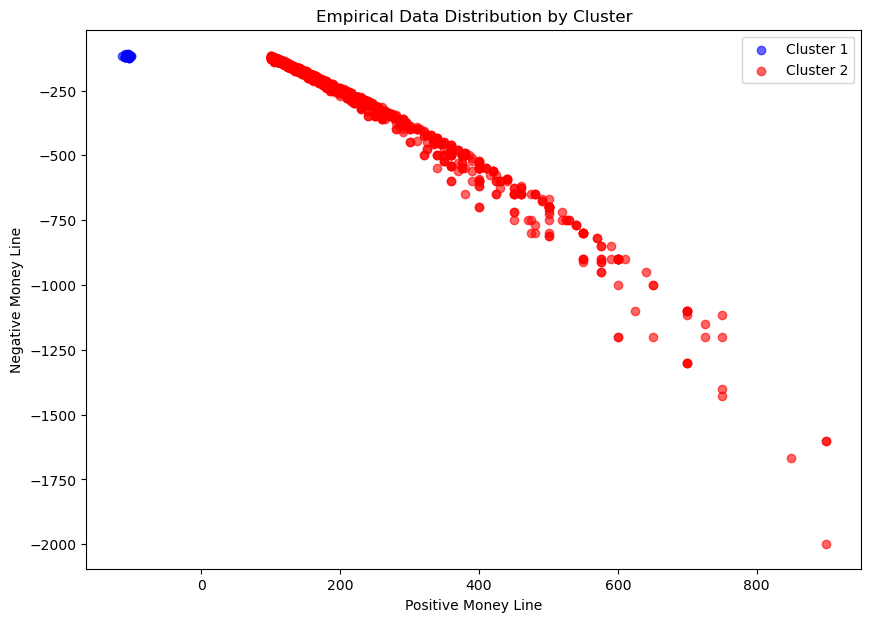

In [66]:
plt.figure(figsize=(10, 7))
for cluster, group in df.groupby('cluster'):
    if cluster == 1:
        color = 'blue'
        label = 'Cluster 1'
    else:
        color = 'red'
        label = 'Cluster 2'
    plt.scatter(group['pos_money'], group['neg_money'], label=label, color=color, alpha=0.6)
plt.title('Empirical Data Distribution by Cluster')
plt.xlabel('Positive Money Line')
plt.ylabel('Negative Money Line')
plt.legend()
plt.show()


# Classical Generative Model

1. Calculate p for falling in Cluster 1 (Gaussian) or Cluster 2 (Linear)
2. Generate Bernoulli(p)
3. If Cluster 1:
    * Sample from bivariate gaussian with mean and cov equal to the empirical metrics
4. If Cluster 2:
    * Use Gamma dist to sample pos_moneyline (find MLE estimate for params given the data)
    * Fit least squares model 1 for residuals (models heteroscedasticity
    * Fit least squares model 2 to data
    * Add residuals to generated y value when sampling

In [67]:
def gamma_NLL(params, data):
    k, theta, shift = params
    if k <= 0 or theta <= 0 or shift > np.min(data):
        return np.inf
    shifted_data = data - shift
    n = len(data)
    nll = -((k - 1) * np.sum(np.log(shifted_data)) 
            - (np.sum(shifted_data) / theta) 
            - n * k * np.log(theta) 
            - n * sp.gammaln(k))
    return nll
def gaussian_neg_log_likelihood(params, x, y):
    """
    Calculate the negative log likelihood for the model:
      Y | X ~ N( b0 + b1*x + b2*x^2, exp(alpha0 + alpha1*x) )
    
    Parameters:
      params : array-like, [b0, b1, b2, alpha0, alpha1]
      x      : predictor values (numpy array)
      y      : response values (numpy array)
      
    Returns:
      nll : negative log likelihood value (float)
    """
    b0, b1, b2, alpha0, alpha1 = params
    # Mean function: mu = b0 + b1*x + b2*x^2
    mu = b0 + b1 * x + b2 * x**2
    # Variance function: sigma^2 = exp(alpha0 + alpha1*x)
    sigma2 = np.exp(alpha0 + alpha1 * x)
    # Calculate the negative log likelihood
    nll = 0.5 * np.sum(np.log(2 * np.pi) + (alpha0 + alpha1 * x) + ((y - mu)**2) / sigma2)
    return nll

In [68]:
class StatGenModel:
    """
    A statistical model that generates parameters based on empirical data.
    
    Attributes:
        emp_data (pd.DataFrame): The original data.
        c1_data (np.ndarray): Numpy array of data for cluster 1.
        c2_data (np.ndarray): Numpy array of data for cluster 2.
        c1_params (dict): Dictionary containing parameters (mean and covariance) for cluster 1.
    """
    
    def __init__(self):
        """
        Initialize the StatGenModel with a DataFrame containing a 'cluster' column.
        """
        # Initialize all attributes as None
        self.emp_data = None  # Original empirical data
        self.c1_prob = None   # Probability of being in cluster 1
        self.c1_data = None   # Data points in cluster 1
        self.c2_data = None   # Data points in cluster 2
        self.c1_params = None # Parameters for cluster 1 model
        self.c2_params = None # Parameters for cluster 2 model
        self.gen_data = None  # Generated synthetic data


    def fit(self, data):
        # Ensure that the 'cluster' column exists
        if 'cluster' not in data.columns:
            raise ValueError("Data must contain a 'cluster' column.")
     
        # Store data and split into clusters
        self.emp_data = data
        self.c1_data = data[data['cluster'] == 1].drop(['cluster'], axis=1).to_numpy()
        self.c2_data = data[data['cluster'] == 2].drop(['cluster'], axis=1).to_numpy()
        
        # Calculate probability of cluster 1
        self.c1_prob = self.c1_data.shape[0] / self.emp_data.shape[0]
        
        # Fit parameters for both clusters
        self.c1_params = self.fit_c1_params()
        self.c2_params = self.fit_c2_params()
    
    
    def fit_c1_params(self):
        """
        Calculate the mean and covariance matrix for cluster 1 data.
        Returns:
            dict: A dictionary with keys 'mu' and 'sigma'.
        """
        # Calculate mean vector and covariance matrix
        mu = self.c1_data.mean(axis=0)
        sigma = np.cov(self.c1_data, rowvar=False)
        return {'mu': mu, 'sigma': sigma}

    def fit_c2_params(self):
        # Initial guess for gaussian model parameters
        init_params = np.array([0.0, 0.0, 0.0, 0.0, 0.0])
        
        # Fit gaussian model using maximum likelihood
        result = minimize(gaussian_neg_log_likelihood, init_params, args=(self.c2_data[:, 0], self.c2_data[:, 1]), method='L-BFGS-B')

        if result.success:
            est_params = result.x
        else:
            raise RuntimeError("Optimization failed:", result.message)
        
        # Fit gamma distribution parameters
        gamma_params = self.fit_c2_gamma_MLEs()

        # Return all fitted parameters
        return {
            'gamma_shape': gamma_params['shape'], 
            'gamma_scale': gamma_params['scale'], 
            'gamma_shift': gamma_params['shift'],
            'b0': est_params[0], 
            'b1': est_params[1], 
            'b2': est_params[2], 
            'a0': est_params[3], 
            'a1': est_params[4]
        }

    
    def fit_c2_gamma_MLEs(self):
        # Fixed shift parameter for gamma distribution
        shift = 100
        
        # Calculate shifted data
        shifted_data = self.c2_data[:, 0] - shift
        
        # Initial parameter estimates using method of moments
        k_init_moment = (np.mean(shifted_data) ** 2) / np.var(shifted_data, ddof=1)
        theta_init = np.mean(shifted_data) / k_init_moment
        
        # Fit gamma parameters using maximum likelihood
        result = minimize(
            fun=gamma_NLL, 
            x0=[k_init_moment, theta_init, shift], 
            args=(self.c2_data[:, 0],), 
            method="L-BFGS-B", 
            bounds=[(0.01, None), (0.01, None), (shift, shift)]
        )
        
        # Extract MLE estimates
        k_mle, theta_mle, shift_mle = result.x
        return {'shape': k_mle, 'scale': theta_mle, 'shift': shift_mle}

    def plot_clusters(self):
        # Create figure with two subplots
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))
        
        # Plot Cluster 1 data
        ax1.scatter(self.c1_data[:, 0], self.c1_data[:, 1], color='blue', alpha=0.7)
        ax1.set_title("Scatter Plot of Cluster 1")
        ax1.set_xlabel("Positive Moneyline")
        ax1.set_ylabel("Negative Moneyline")
        
        # Plot Cluster 2 data
        ax2.scatter(self.c2_data[:, 0], self.c2_data[:, 1], color='red', alpha=0.7)
        ax2.set_title("Scatter Plot of Cluster 2")
        ax2.set_xlabel("Positive Moneyline")
        ax2.set_ylabel("Negative Moneyline")
        
        plt.tight_layout()
        plt.show()
    
    def plot_gamma(self):
        # Create histogram of cluster 2 positive moneyline data
        plt.figure(figsize=(10, 7))
        count, bins, _ = plt.hist(self.c2_data[:,0], bins=30, density=True, alpha=0.6, color='g', label='Data Histogram')

        # Generate points for fitted gamma PDF
        x_values = np.linspace(self.c2_data[:,0].min(), self.c2_data[:,0].max(), 100)
        shifted_x = x_values - self.c2_params['gamma_shift']
        pdf_values = gamma_dist.pdf(shifted_x, 
                                  a=self.c2_params['gamma_shape'], 
                                  scale=self.c2_params['gamma_scale'])

        # Plot fitted PDF over histogram
        plt.plot(x_values, pdf_values, 'r-', lw=2, label='Fitted Shifted Gamma PDF')
        plt.title("Fitted Shifted Gamma Distribution")
        plt.xlabel("Data")
        plt.ylabel("Density")
        plt.legend()
        plt.show()

    def plot_c2_model(self):
        # Extract data and parameters
        x = self.c2_data[:, 0]
        y = self.c2_data[:, 1]
        
        b0, b1, b2 = self.c2_params['b0'], self.c2_params['b1'], self.c2_params['b2']  
        alpha0, alpha1 = self.c2_params['a0'], self.c2_params['a1']  
        
        # Create grid for smooth curve plotting
        x_grid = np.linspace(np.min(x), np.max(x), 300)
        
        # Calculate mean and standard deviation predictions
        mu_grid = b0 + b1 * x_grid + b2 * x_grid**2
        sigma_grid = np.sqrt(np.exp(alpha0 + alpha1 * x_grid))

        # Create visualization
        plt.figure(figsize=(8, 6))
        plt.scatter(x, y, label='Data', color='blue', alpha=0.6)
        plt.plot(x_grid, mu_grid, label='Fitted Mean', color='red', linewidth=2)
        plt.fill_between(x_grid, mu_grid - sigma_grid, mu_grid + sigma_grid,
                        color='red', alpha=0.2, label='±1 Std. Dev.')

        plt.xlabel('X')
        plt.ylabel('Y')
        plt.title('Fitted Model with Heteroscedasticity')
        plt.legend()
        plt.show()

    def plot_generated_data(self, show_real_data=True):
        # Plot comparison of real and synthetic data
        plt.figure(figsize=(8, 6))
        if show_real_data:
            plt.scatter(self.emp_data['pos_money'], self.emp_data['neg_money'] ,label='Real Data', color='blue', alpha=0.6)
        plt.scatter(self.gen_data[:, 0], self.gen_data[:, 1] ,label='Generated Data', color='orange', alpha=0.6)
        plt.xlabel('Postitive Moneyline')
        plt.ylabel('Negative Moneyline')
        plt.title('Generated Moneyline Data')
        plt.legend()
        plt.show()
    
    def plot_generated_clusters(self):
        # Create figure with two subplots
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))
        
        # Generate data for each cluster separately
        c1_data = self.generate_c1(size=1000)
        c2_data = self.generate_c2(size=1000)
        
        # Plot Cluster 1 generated data
        ax1.scatter(c1_data[:, 0], c1_data[:, 1], color='blue', alpha=0.7)
        ax1.set_title("Generated Data - Cluster 1")
        ax1.set_xlabel("Positive Moneyline")
        ax1.set_ylabel("Negative Moneyline")
        
        # Plot Cluster 2 generated data
        ax2.scatter(c2_data[:, 0], c2_data[:, 1], color='red', alpha=0.7)
        ax2.set_title("Generated Data - Cluster 2")
        ax2.set_xlabel("Positive Moneyline")
        ax2.set_ylabel("Negative Moneyline")
        
        plt.tight_layout()
        plt.show()

    def plot_marginal_distributions(self):
        """
        Plot marginal distributions of positive and negative moneylines for both real and generated data.
        """
        # Create figure with two subplots
        fig, axes = plt.subplots(1, 2, figsize=(14, 5))
        
        # Plot positive moneyline distributions
        sns.histplot(self.emp_data['pos_money'], kde=True, color='blue', label='Real', ax=axes[0])
        sns.histplot(self.gen_data[:, 0], kde=True, color='orange', label='Generated', ax=axes[0])
        axes[0].set_title('Distribution of Positive Money Line')
        axes[0].legend()
        
        # Plot negative moneyline distributions
        sns.histplot(self.emp_data['neg_money'], kde=True, color='blue', label='Real', ax=axes[1])
        sns.histplot(self.gen_data[:, 1], kde=True, color='orange', label='Generated', ax=axes[1])
        axes[1].set_title('Distribution of Negative Money Line')
        axes[1].legend()
        
        plt.tight_layout()
        plt.show()

    def generate(self):
        # Generate synthetic data points
        size = len(self.emp_data)
        generated_data = np.zeros(shape=(size,2))
        for i in range(size):
            # Randomly assign cluster based on empirical probabilities
            cluster = np.random.binomial(n=1, p=1-self.c1_prob) + 1
            if cluster == 1:
                generated_data[i] = self.generate_c1()
            else:
                generated_data[i] = self.generate_c2()
        self.gen_data = generated_data
        return generated_data


    def generate_c1(self, size = 1):
        # Generate from bivariate normal distribution for cluster 1
        return rng.multivariate_normal(self.c1_params['mu'], self.c1_params['sigma'], size=size)
    
    def generate_c2(self, size = 1):
        # Extract model parameters
        b0, b1, b2 = self.c2_params['b0'], self.c2_params['b1'], self.c2_params['b2']  
        alpha0, alpha1 = self.c2_params['a0'], self.c2_params['a1']  

        # Get empirical max
        emp_max = self.emp_data['pos_money'].max()

        # Calculate P = F(emp_max) for gamma CDF
        P = gamma_dist.cdf(emp_max - self.c2_params['gamma_shift'],
                          a=self.c2_params['gamma_shape'],
                          scale=self.c2_params['gamma_scale'])

        # Sample u from Uniform(0,P)
        u = np.random.uniform(0, P, size=size)

        # Sample x_sim from inverse CDF (PPF) using u
        x_sim = gamma_dist.ppf(u,
                              a=self.c2_params['gamma_shape'],
                              scale=self.c2_params['gamma_scale']) + self.c2_params['gamma_shift']

        # Calculate mean and standard deviation for each x value
        mu_sim = b0 + b1 * x_sim + b2 * x_sim**2
        sigma_sim = np.sqrt(np.exp(alpha0 + alpha1 * x_sim))

        # Generate y values from heteroscedastic normal distribution
        y_sim = np.random.normal(loc=mu_sim, scale=sigma_sim)

        return np.array([x_sim, y_sim]).T
    
    def perform_ks_tests(self):
        """
        Perform Kolmogorov-Smirnov tests for both marginal distributions and joint distribution.
        Compares real data with generated data.
        """
        from scipy import stats
        
        # Perform KS test for positive moneyline
        ks_pos = stats.ks_2samp(self.emp_data['pos_money'], self.gen_data[:, 0])
        
        # Perform KS test for negative moneyline
        ks_neg = stats.ks_2samp(self.emp_data['neg_money'], self.gen_data[:, 1])
        
        # Perform 2D KS test for joint distribution
        real_data = np.column_stack((self.emp_data['pos_money'], self.emp_data['neg_money']))
        ks_2d = stats.ks_2samp(real_data.flatten(), self.gen_data.flatten())
        
        # Print results
        print("Kolmogorov-Smirnov Test Results:")
        print("\nPositive Moneyline:")
        print(f"KS statistic: {ks_pos.statistic:.4f}")
        print(f"p-value: {ks_pos.pvalue:.4f}")
        print(f"Null hypothesis (distributions are the same): {'Not rejected' if ks_pos.pvalue > 0.05 else 'Rejected'}")
        
        print("\nNegative Moneyline:")
        print(f"KS statistic: {ks_neg.statistic:.4f}")
        print(f"p-value: {ks_neg.pvalue:.4f}")
        print(f"Null hypothesis (distributions are the same): {'Not rejected' if ks_neg.pvalue > 0.05 else 'Rejected'}")
        
        print("\nJoint Distribution:")
        print(f"KS statistic: {ks_2d.statistic:.4f}")
        print(f"p-value: {ks_2d.pvalue:.4f}")
        print(f"Null hypothesis (distributions are the same): {'Not rejected' if ks_2d.pvalue > 0.05 else 'Rejected'}")
        
        # return {
        #     'positive': {'statistic': ks_pos.statistic, 'pvalue': ks_pos.pvalue},
        #     'negative': {'statistic': ks_neg.statistic, 'pvalue': ks_neg.pvalue},
        #     'joint': {'statistic': ks_2d.statistic, 'pvalue': ks_2d.pvalue}
        # }
    def calculate_wasserstein_distances(self):
        """
        Calculate Wasserstein distances between real and generated distributions
        for both positive and negative moneylines.
        
        Returns:
            dict: Dictionary containing Wasserstein distances for both distributions
        """
        from scipy.stats import wasserstein_distance
        
        # Calculate Wasserstein distance for positive moneyline
        wd_pos = wasserstein_distance(self.emp_data['pos_money'], self.gen_data[:, 0])
        
        # Calculate Wasserstein distance for negative moneyline
        wd_neg = wasserstein_distance(self.emp_data['neg_money'], self.gen_data[:, 1])
        
        # Print results
        print("Wasserstein Distance Results:")
        print(f"\nPositive Moneyline: {wd_pos:.4f}")
        print(f"Negative Moneyline: {wd_neg:.4f}")
        
        return {
            'positive': wd_pos,
            'negative': wd_neg
        }

In [69]:
m1 = StatGenModel()
m1.fit(df)
m1.generate()

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


array([[ 190.48857994, -238.29192862],
       [ 633.89043403, -798.12767438],
       [ 205.51143177, -246.85579385],
       ...,
       [ 112.99706524, -128.05161047],
       [ 491.03901902, -739.22819631],
       [ 236.53016813, -299.27380631]])

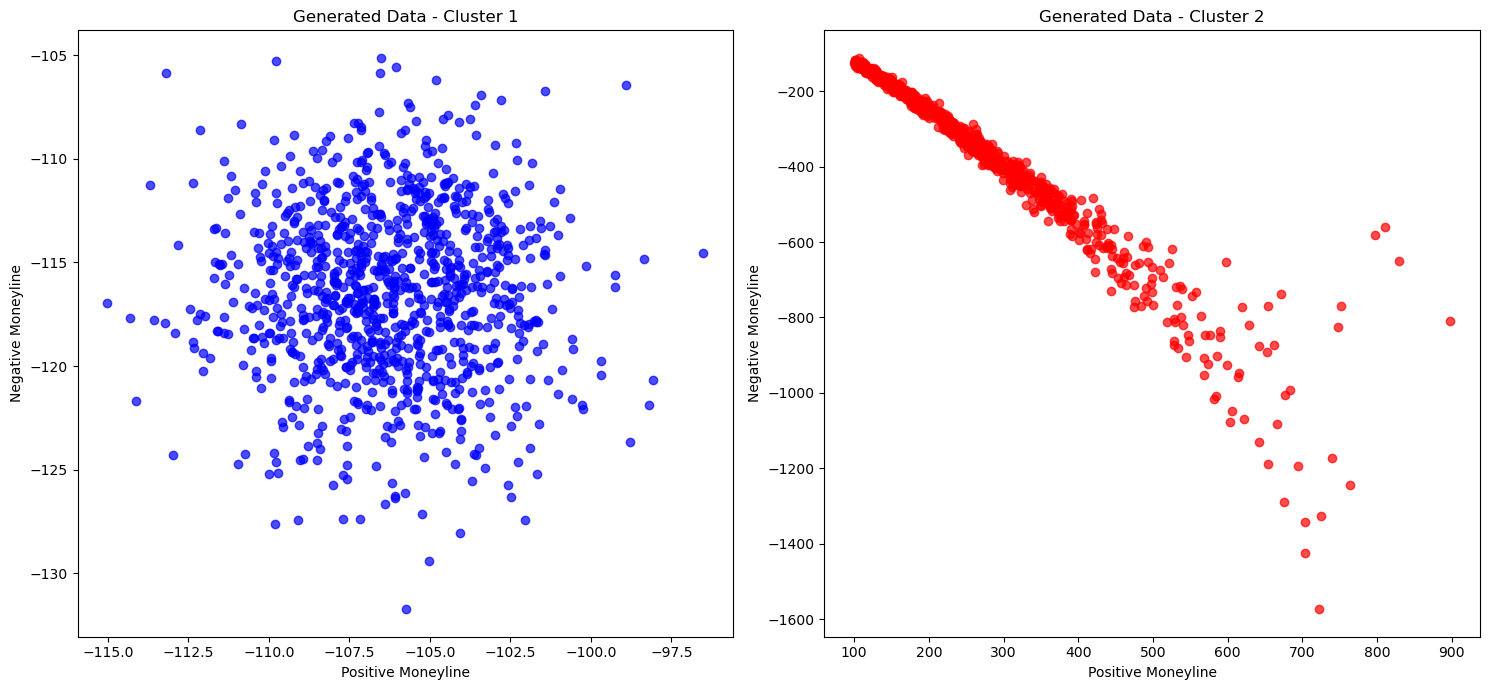

In [70]:
m1.plot_generated_clusters()

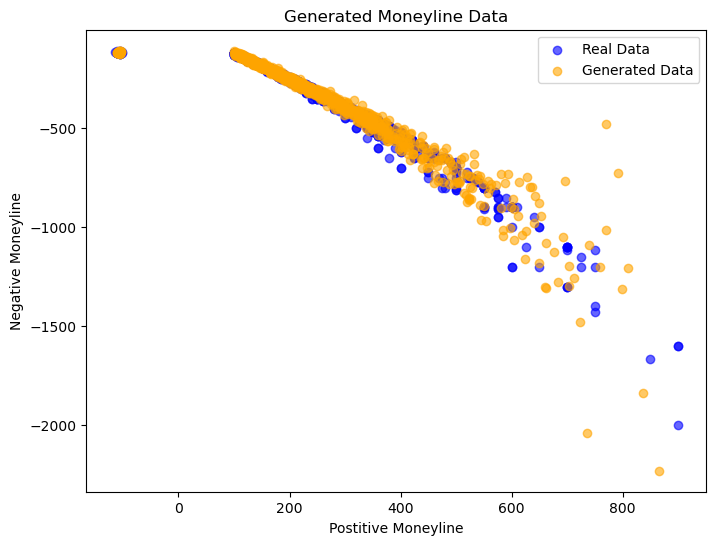

In [71]:
m1.plot_generated_data(show_real_data=True)

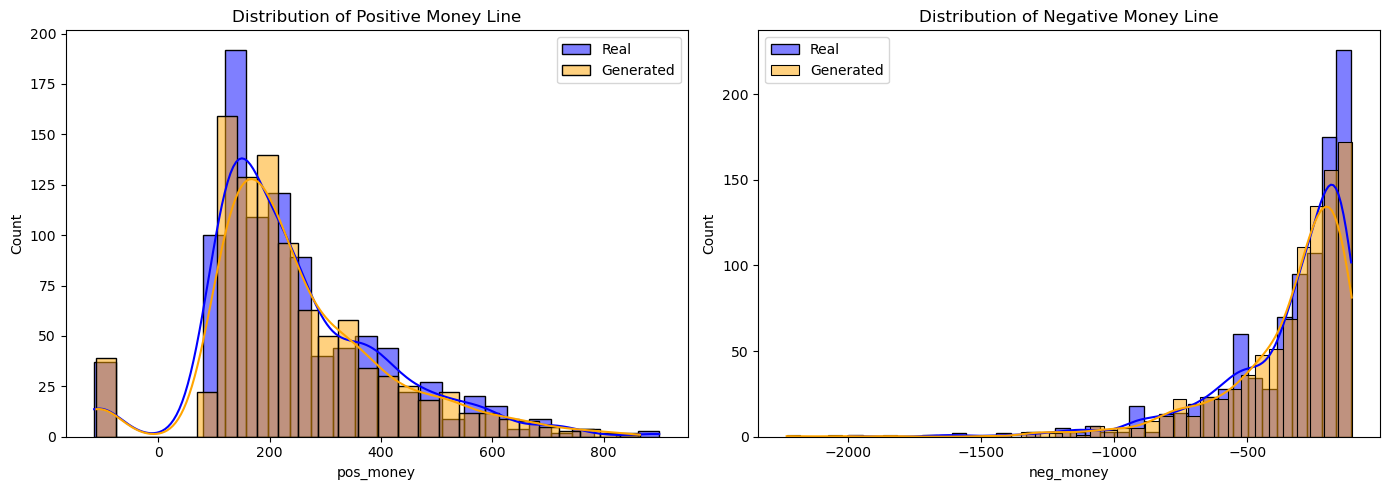

In [72]:
m1.plot_marginal_distributions()

In [73]:
m1.perform_ks_tests()

Kolmogorov-Smirnov Test Results:

Positive Moneyline:
KS statistic: 0.0690
p-value: 0.0225
Null hypothesis (distributions are the same): Rejected

Negative Moneyline:
KS statistic: 0.0754
p-value: 0.0095
Null hypothesis (distributions are the same): Rejected

Joint Distribution:
KS statistic: 0.0377
p-value: 0.1377
Null hypothesis (distributions are the same): Not rejected


In [74]:
m1.calculate_wasserstein_distances()

Wasserstein Distance Results:

Positive Moneyline: 7.6888
Negative Moneyline: 12.6154


{'positive': 7.688789963143945, 'negative': 12.615397608256213}